In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc



# PREDICCIÓ DE EXIT DEL JOC

Amb aquest cas, el nostre objectiu serà reconeixer quins son els factors mes importants de cara a l'exit en ventes que tindrà un joc i intentar fer un classificador que ens permeti prefir si un joc serà exitos o no segons les seves característiques donades.

#DEFINICIÓ D'EXIT PER A UN JOC
Des de aquest projecte, hem plantejat 2 possibles mesures per saber si un joc ha tingut exit o no:
- La valoracio de critics mes alta
- El numero de vendes que ha tingut un joc

La nostra base dades te la següent forma:


In [143]:
print('')
sales_train = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
display(sales_train)
print('')


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16715,LMA Manager 2007,X360,2006.0,Sports,Codemasters,0.00,0.01,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16716,Haitaka no Psychedelica,PSV,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16717,Spirits & Spells,GBA,2003.0,Platform,Wanadoo,0.01,0.00,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN




#TRACTAMENT DE NANS
Primer comprovarem quants Nans hi ha en aquesta base da dades per saber com poder tractar-los, aixo ho farem de la següent manera:



Aixo es el % de nans de les primeres 100 files:
0        0.000
1        0.375
2        0.000
3        0.000
4        0.375
         ...  
16714    0.375
16715    0.375
16716    0.375
16717    0.375
16718    0.375
Length: 16719, dtype: float64
Aqui comprovem si la taula te nans
NaNs: True
I Per ultim comprovem el % de nans que hi ha per columna


Platform            0.000000
NA_Sales            0.000000
EU_Sales            0.000000
JP_Sales            0.000000
Other_Sales         0.000000
Global_Sales        0.000000
Name                0.011962
Genre               0.011962
Publisher           0.322986
Year_of_Release     1.608948
Developer          39.613613
User_Score         40.098092
Rating             40.486871
Critic_Score       51.330821
Critic_Count       51.330821
User_Count         54.602548
dtype: float64

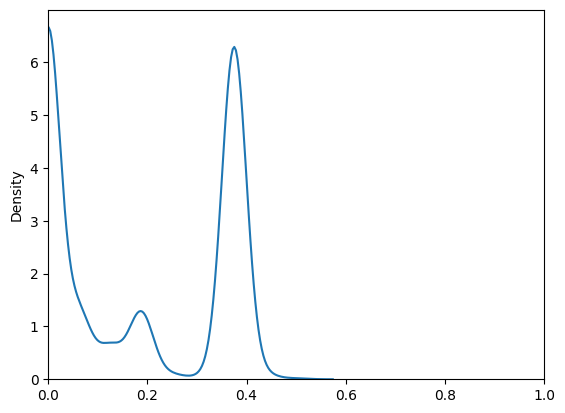

In [144]:
def has_nans(df):
  return df.isna().sum().sum()>0

def get_percentage_nan_per_column(df):
  return df.isna().sum().sort_values()/len(df)*100.

percent_nan_fila = sales_train.isna().mean(axis = 1)

print('Aixo es el % de nans de les primeres 100 files:')
print(percent_nan_fila)
print('Aqui comprovem si la taula te nans')
print('NaNs:', has_nans(sales_train))
print('I Per ultim comprovem el % de nans que hi ha per columna')

percentage_nan = get_percentage_nan_per_column(sales_train)
display(percentage_nan)
print('')

sns.kdeplot(percent_nan_fila)
plt.xlim(0,1)
plt.show()

Provem a eliminar totes les files que tenen nans per veure si les dades restants serien suficients com per poder realitzar un entrenament correcte del nostre predictor:


In [145]:
sales_train = sales_train.dropna()
display(sales_train)


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16667,E.T. The Extra-Terrestrial,GBA,2001.0,Action,NewKidCo,0.01,0.00,0.00,0.00,0.01,46.0,4.0,2.4,21.0,Fluid Studios,E
16677,Mortal Kombat: Deadly Alliance,GBA,2002.0,Fighting,Midway Games,0.01,0.00,0.00,0.00,0.01,81.0,12.0,8.8,9.0,Criterion Games,M
16696,Metal Gear Solid V: Ground Zeroes,PC,2014.0,Action,Konami Digital Entertainment,0.00,0.01,0.00,0.00,0.01,80.0,20.0,7.6,412.0,Kojima Productions,M
16700,Breach,PC,2011.0,Shooter,Destineer,0.01,0.00,0.00,0.00,0.01,61.0,12.0,5.8,43.0,Atomic Games,T


Com podem veure, despres de treure totes les files que contenen nans, tenim una base de dades amb 6825 files, per tant la considerarem suficientment grossa de moment com per poder realitzar un entrenament amb aquestes dades.

#ENTRENAMENT DEL CLASSIFICADOR
Primer haurem de tractar les dades catagoriques com pot ser el equip desenvolupador, els publicadors del joc, el genere i la plataforma

In [146]:
mod = sales_train
mod.Platform = pd.Categorical(mod.Platform)
mod.Platform = mod.Platform.cat.codes
mod.Publisher = pd.Categorical(mod.Publisher)
mod.Publisher = mod.Publisher.cat.codes
mod.Rating = pd.Categorical(mod.Rating)
mod.Rating = mod.Rating.cat.codes
mod.Genre = pd.Categorical(mod.Genre)
mod.Genre = mod.Genre.cat.codes
mod.Developer = pd.Categorical(mod.Developer)
mod.Developer = mod.Developer.cat.codes
mod.User_Score = pd.Categorical (mod.User_Score)
mod.User_Score = mod.User_Score.cat.codes
mod.Critic_Score = pd.Categorical (mod.Critic_Score)
mod.Critic_Score = mod.Critic_Score.cat.codes
mod['Critic_Score'] = pd.cut(mod['Critic_Score'],bins = 10, labels = False)
mod['User_Score'] = pd.cut(mod['User_Score'],bins = 10, labels = False)


mod['Global_Sales'] = mod['Global_Sales'] > mod['Global_Sales'].median()
mod['NA_Sales'] = mod['NA_Sales'] > mod['NA_Sales'].median()
mod['EU_Sales'] = mod['EU_Sales'] > mod['EU_Sales'].median()
mod['JP_Sales'] = mod['JP_Sales'] > mod['JP_Sales'].median()
mod_sense_ventes_parcials = mod.drop(['NA_Sales','EU_Sales','JP_Sales','Other_Sales'],axis=1)
mod_NA = mod.drop(['Global_Sales','EU_Sales','JP_Sales','Other_Sales'],axis=1)
mod_EU = mod.drop(['NA_Sales','Global_Sales','JP_Sales','Other_Sales'],axis=1)
mod_JP = mod.drop(['NA_Sales','EU_Sales','Global_Sales','Other_Sales'],axis=1)
mod_others = mod.drop(['NA_Sales','EU_Sales','Global_Sales','JP_Sales'],axis=1)
print('El desvalanceig:')
print(mod_sense_ventes_parcials['Global_Sales'].value_counts())
print(mod_NA['NA_Sales'].value_counts())
print(mod_EU['EU_Sales'].value_counts())
print(mod_JP['JP_Sales'].value_counts())


majoria = mod_JP[mod_JP['JP_Sales'] == False]
modMajoria = majoria.sample(n = len(mod_JP[mod_JP['JP_Sales'] == True]),random_state = 42)
modMinoria =  mod_JP[mod_JP['JP_Sales'] == True]

mod_JP = pd.concat([modMajoria,modMinoria], axis = 0)
print(mod_JP['JP_Sales'].value_counts())

El desvalanceig:
False    3438
True     3387
Name: Global_Sales, dtype: int64
False    3479
True     3346
Name: NA_Sales, dtype: int64
False    3519
True     3306
Name: EU_Sales, dtype: int64
False    4813
True     2012
Name: JP_Sales, dtype: int64
False    2012
True     2012
Name: JP_Sales, dtype: int64


<ipython-input-147-7f831de2f999>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(mod_sense_ventes_parcials.corr(), center=0, annot=True, vmin=-1, vmax=1, cmap="RdBu_r")


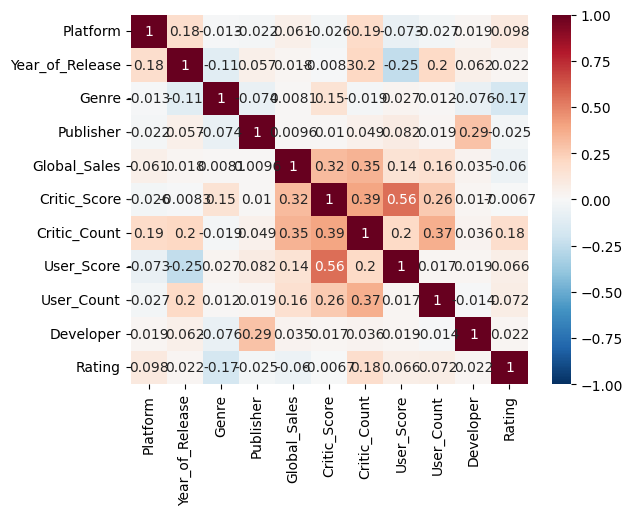

In [147]:
plt.figure()
sns.heatmap(mod_sense_ventes_parcials.corr(), center=0, annot=True, vmin=-1, vmax=1, cmap="RdBu_r")
plt.show()

#DECISION TREE CLASSIFIER amb critiques

In [148]:
X = mod_sense_ventes_parcials.drop(['Global_Sales','Name','User_Count','Critic_Count'],axis = 1)
y = mod_sense_ventes_parcials['Global_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
Dec = DecisionTreeClassifier().fit(X_train, y_train)
c2 = cross_val_score(Dec, X_train, y_train, cv= 7)
print('Aixo es la c2')
print(c2)
print("%0.2f accuracy with a standard deviation of %0.2f" % (c2.mean(), c2.std()))
print('El desvalanceig:')
print(y_train.value_counts())

Aixo es la c2
[0.6954612  0.6398243  0.67935578 0.67302053 0.65102639 0.68768328
 0.67302053]
0.67 accuracy with a standard deviation of 0.02
El desvalanceig:
False    2408
True     2369
Name: Global_Sales, dtype: int64


#LOGISTIC REGRESSION amb critics

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)
logi = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))
logi.fit(X_train, y_train)
c2 = cross_val_score(Dec, X_train, y_train)
print('El train es: ')
print(c2)
print("%0.2f accuracy with a standard deviation of %0.2f" % (c2.mean(), c2.std()))

El train es: 
[0.68554688 0.66210938 0.69433594 0.67057674 0.6568915 ]
0.67 accuracy with a standard deviation of 0.01


#RANDOM FOREST amb critics


In [150]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)
RF = RandomForestClassifier().fit(X_train, y_train)
c2 = cross_val_score(Dec, X_train, y_train)
print(c2)
print("%0.2f accuracy with a standard deviation of %0.2f" % (c2.mean(), c2.std()))

[0.67578125 0.66308594 0.68554688 0.67937439 0.6627566 ]
0.67 accuracy with a standard deviation of 0.01


#Quins son els principals factors aleshores?

              precision    recall  f1-score   support

       False       0.72      0.75      0.73       862
        True       0.73      0.70      0.72       845

    accuracy                           0.72      1707
   macro avg       0.72      0.72      0.72      1707
weighted avg       0.72      0.72      0.72      1707

          Atributo  Importancia
6        Developer     0.187417
3        Publisher     0.154773
4     Critic_Score     0.148863
0         Platform     0.142877
1  Year_of_Release     0.131728
2            Genre     0.098564
5       User_Score     0.082961
7           Rating     0.052816


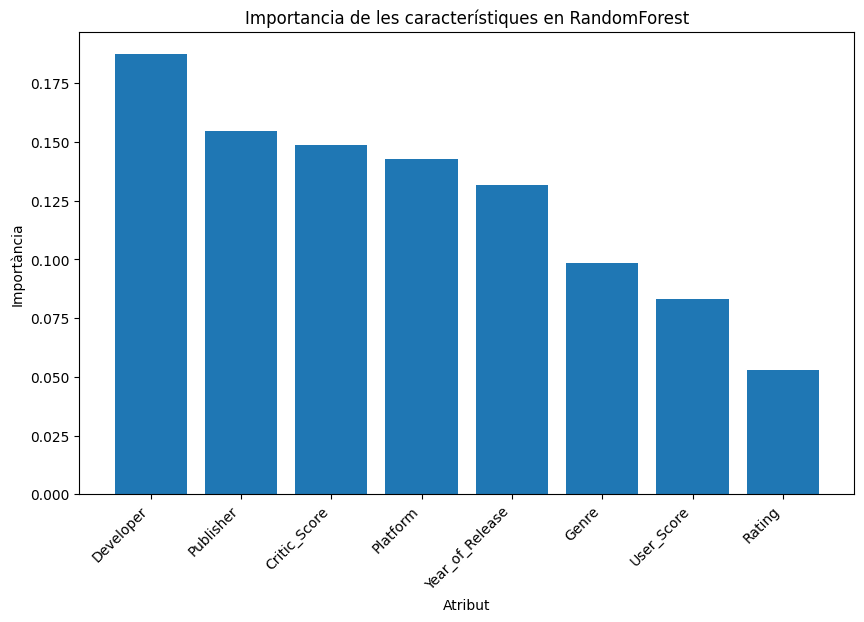

In [151]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['False', 'True'])
print(report)

importancias = clf.feature_importances_
importancias_df = pd.DataFrame({'Atributo': X_train.columns, 'Importancia': importancias})


importancias_df = importancias_df.sort_values(by='Importancia', ascending=False)


print(importancias_df)


plt.figure(figsize=(10, 6))
plt.bar(importancias_df['Atributo'], importancias_df['Importancia'])
plt.title('Importancia de les característiques en RandomForest')
plt.xlabel('Atribut')
plt.ylabel('Importància')
plt.xticks(rotation=45, ha="right")
plt.show()



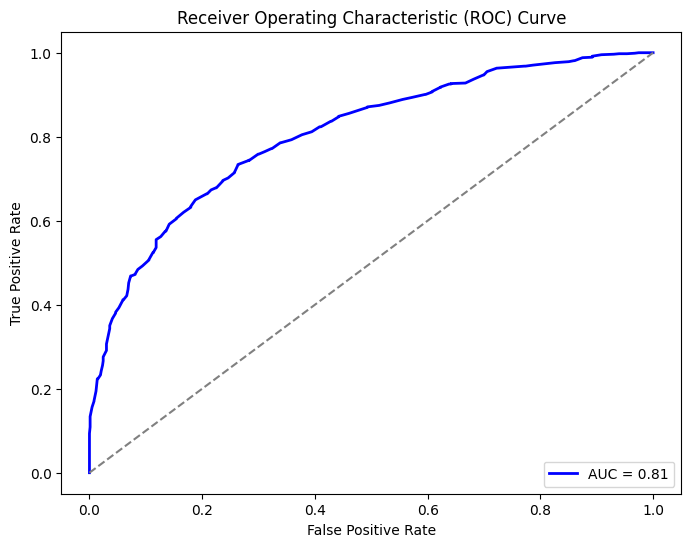

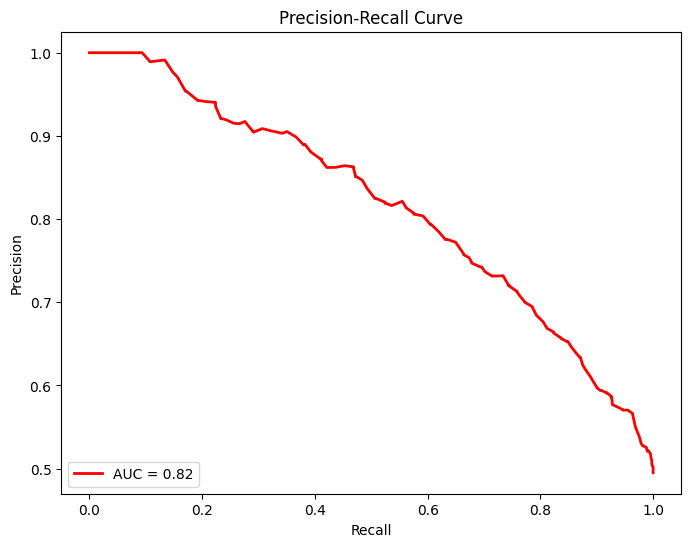

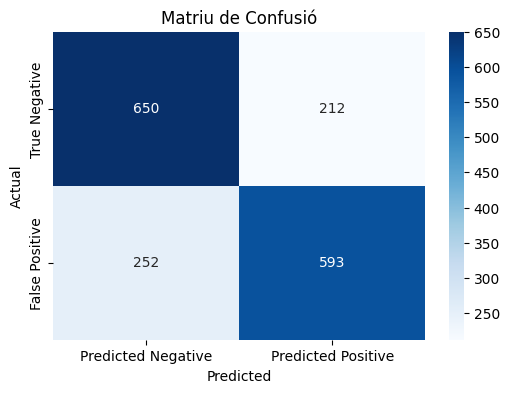

In [152]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)


y_proba = clf.predict_proba(X_test)[:, 1]


fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)


plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='red', lw=2, label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


y_pred = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
labels = ['True Negative', 'False Positive']
labels2 = ['Predicted Negative', 'Predicted Positive']
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels2, yticklabels=labels)
plt.title('Matriu de Confusió')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()











Ara cambiem el target i reduim la zona on volem mirar que agrada mes, començarem per NA


          Atributo  Importancia
6        Developer     0.230690
3        Publisher     0.165845
0         Platform     0.155390
4     Critic_Score     0.123652
1  Year_of_Release     0.118058
2            Genre     0.078564
5       User_Score     0.077692
7           Rating     0.050108


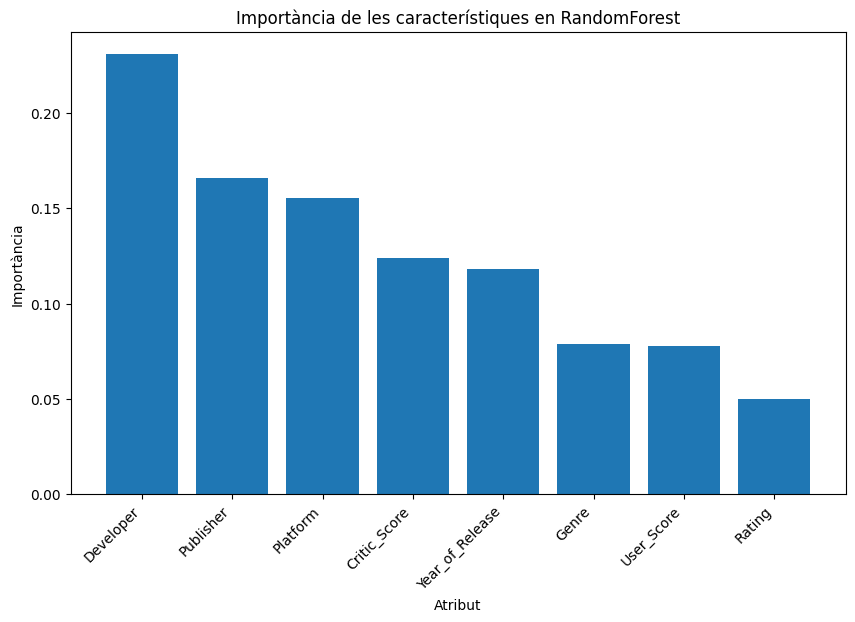

In [153]:
X = mod_NA.drop(['NA_Sales','Name','User_Count','Critic_Count'],axis = 1)
y = mod_NA['NA_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)
clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)



importancias = clf.feature_importances_


importancias_df = pd.DataFrame({'Atributo': X_train.columns, 'Importancia': importancias})


importancias_df = importancias_df.sort_values(by='Importancia', ascending=False)


print(importancias_df)

plt.figure(figsize=(10, 6))
plt.bar(importancias_df['Atributo'], importancias_df['Importancia'])
plt.title('Importància de les característiques en RandomForest')
plt.xlabel('Atribut')
plt.ylabel('Importància')
plt.xticks(rotation=45, ha="right")
plt.show()



              precision    recall  f1-score   support

       False       0.73      0.78      0.76       858
        True       0.76      0.71      0.74       849

    accuracy                           0.75      1707
   macro avg       0.75      0.75      0.75      1707
weighted avg       0.75      0.75      0.75      1707



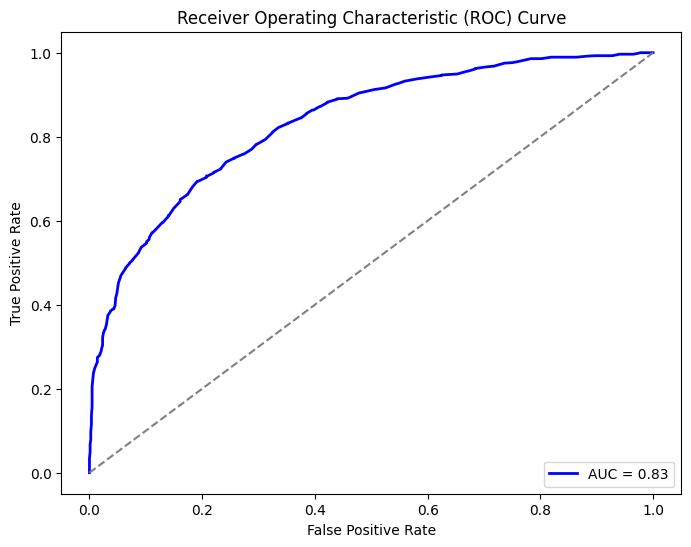

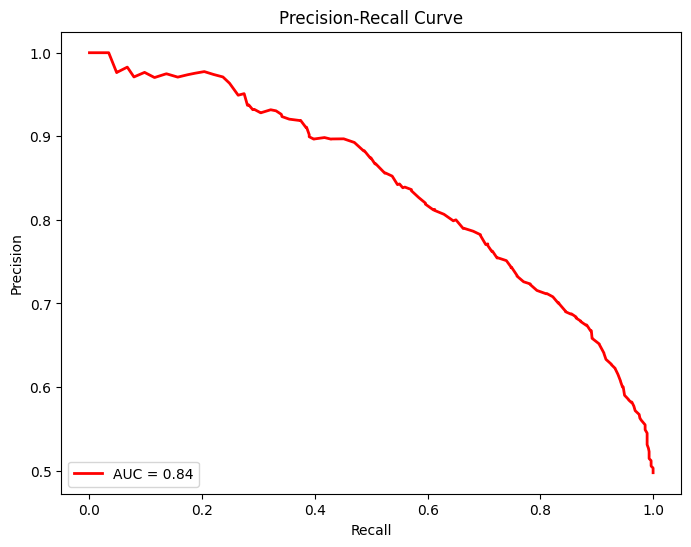

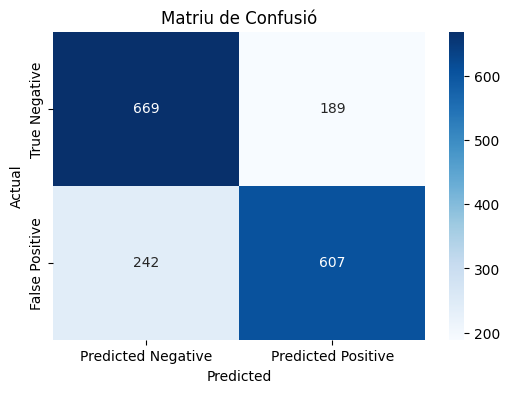

In [154]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['False', 'True'])
print(report)
y_proba = clf.predict_proba(X_test)[:, 1]


fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)


plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='red', lw=2, label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

y_pred = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
labels = ['True Negative', 'False Positive']
labels2 = ['Predicted Negative', 'Predicted Positive']
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels2, yticklabels=labels)
plt.title('Matriu de Confusió')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




          Atributo  Importancia
6        Developer     0.222891
3        Publisher     0.155270
1  Year_of_Release     0.147302
0         Platform     0.134975
4     Critic_Score     0.116657
2            Genre     0.093150
5       User_Score     0.079081
7           Rating     0.050674


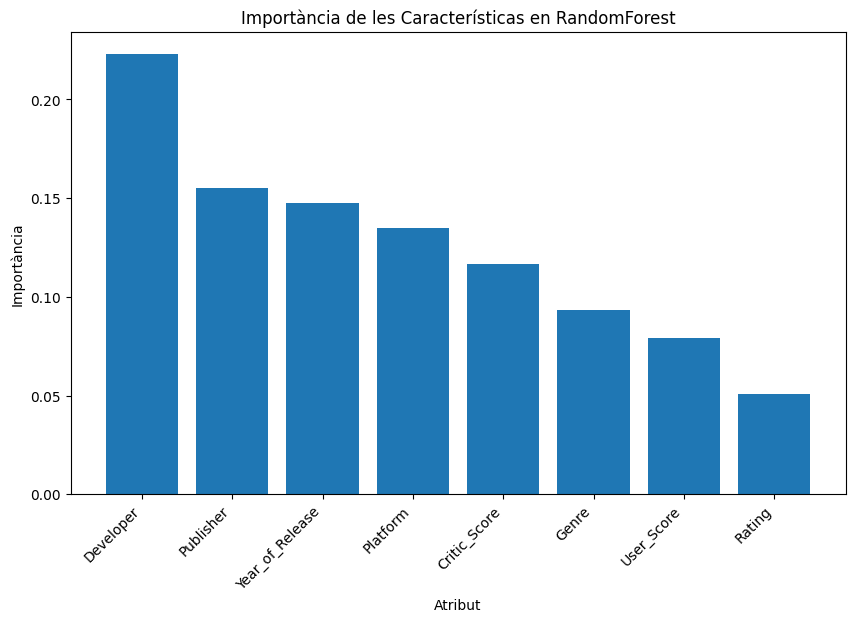

In [155]:
X = mod_EU.drop(['EU_Sales','Name','User_Count','Critic_Count'],axis = 1)
y = mod_EU['EU_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)
clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)



importancias = clf.feature_importances_


importancias_df = pd.DataFrame({'Atributo': X_train.columns, 'Importancia': importancias})


importancias_df = importancias_df.sort_values(by='Importancia', ascending=False)


print(importancias_df)

plt.figure(figsize=(10, 6))
plt.bar(importancias_df['Atributo'], importancias_df['Importancia'])
plt.title('Importància de les Características en RandomForest')
plt.xlabel('Atribut')
plt.ylabel('Importància')
plt.xticks(rotation=45, ha="right")
plt.show()




              precision    recall  f1-score   support

       False       0.71      0.76      0.74       877
        True       0.73      0.68      0.70       830

    accuracy                           0.72      1707
   macro avg       0.72      0.72      0.72      1707
weighted avg       0.72      0.72      0.72      1707



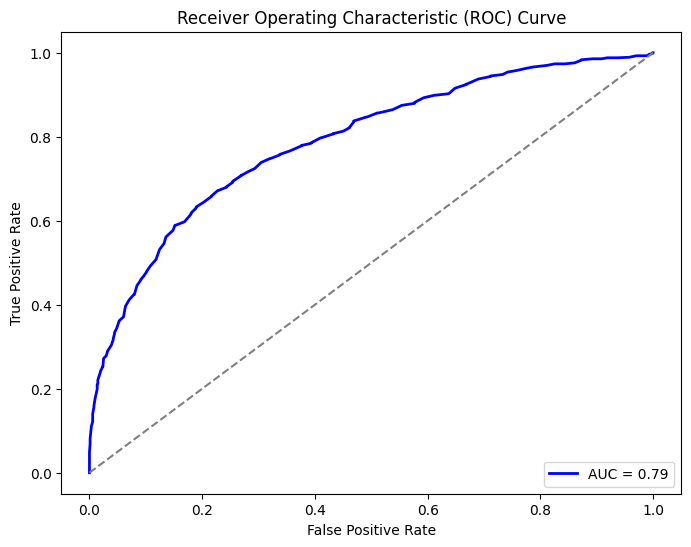

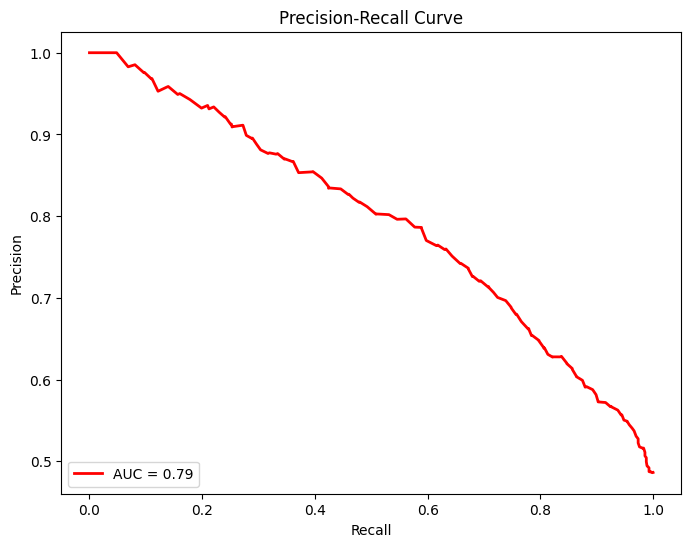

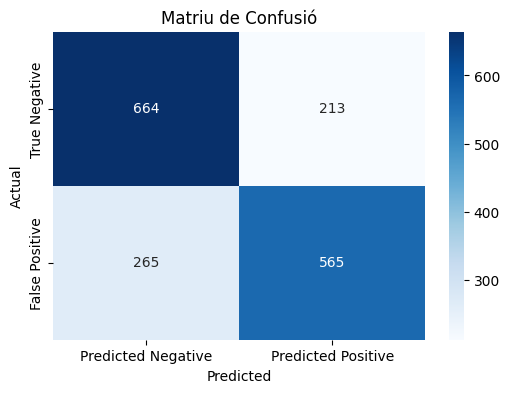

In [156]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['False', 'True'])
print(report)
y_proba = clf.predict_proba(X_test)[:, 1]


fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)


plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='red', lw=2, label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


y_pred = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
labels = ['True Negative', 'False Positive']
labels2 = ['Predicted Negative', 'Predicted Positive']
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels2, yticklabels=labels)
plt.title('Matriu de Confusió')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



          Atributo  Importancia
0         Platform     0.184928
3        Publisher     0.170763
6        Developer     0.162682
1  Year_of_Release     0.149501
4     Critic_Score     0.113424
2            Genre     0.088832
5       User_Score     0.066658
7           Rating     0.063212


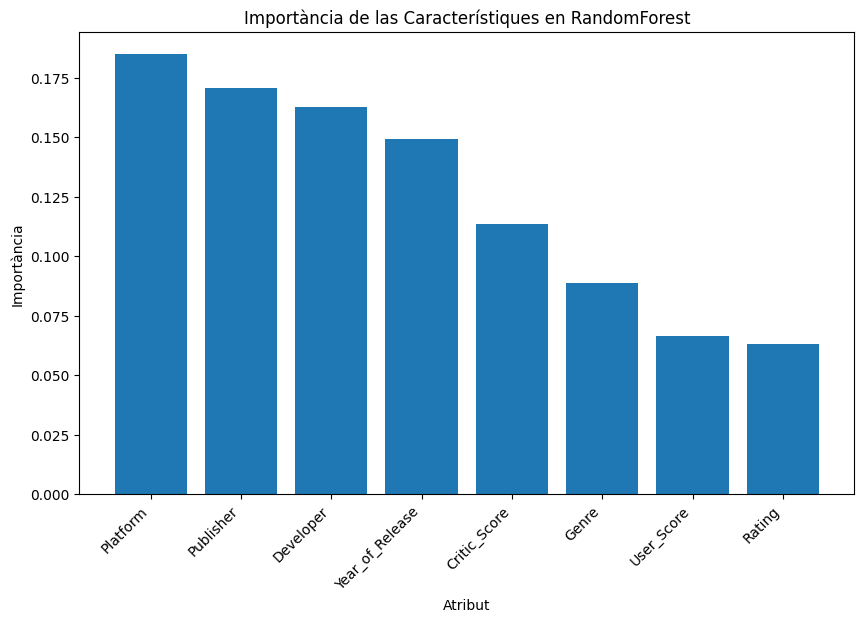

In [157]:
X = mod_JP.drop(['JP_Sales','Name','User_Count','Critic_Count'],axis = 1)
y = mod_JP['JP_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)
clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)

importancias = clf.feature_importances_


importancias_df = pd.DataFrame({'Atributo': X_train.columns, 'Importancia': importancias})


importancias_df = importancias_df.sort_values(by='Importancia', ascending=False)


print(importancias_df)

plt.figure(figsize=(10, 6))
plt.bar(importancias_df['Atributo'], importancias_df['Importancia'])
plt.title('Importància de las Característiques en RandomForest')
plt.xlabel('Atribut')
plt.ylabel('Importància')
plt.xticks(rotation=45, ha="right")
plt.show()



              precision    recall  f1-score   support

       False       0.81      0.81      0.81       513
        True       0.80      0.80      0.80       493

    accuracy                           0.80      1006
   macro avg       0.80      0.80      0.80      1006
weighted avg       0.80      0.80      0.80      1006



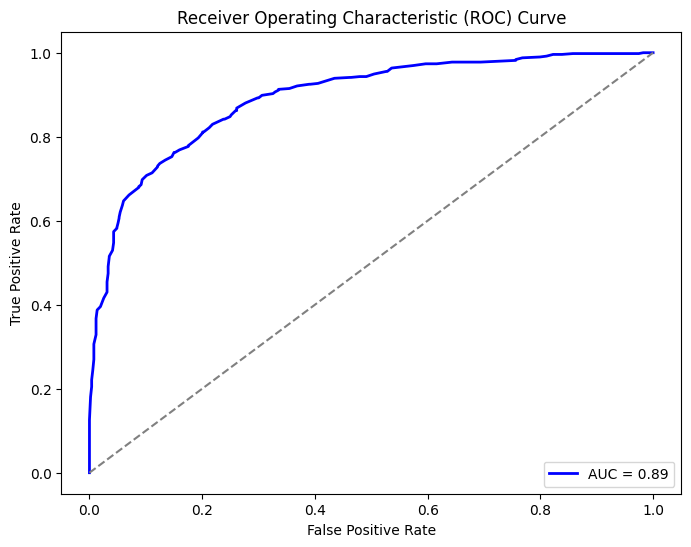

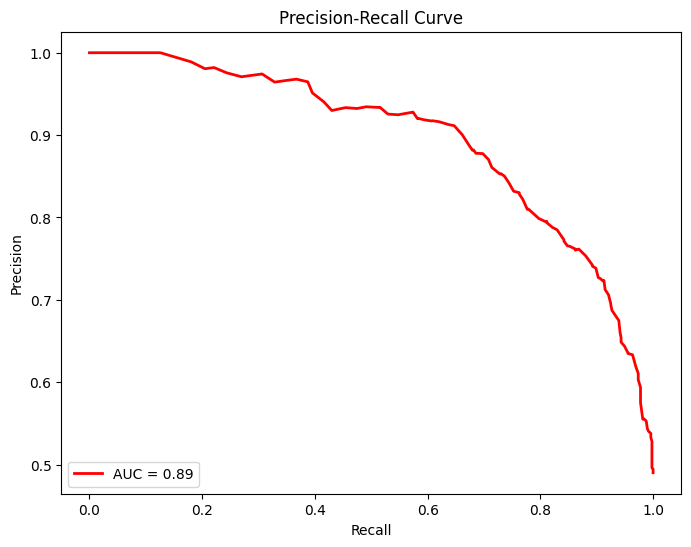

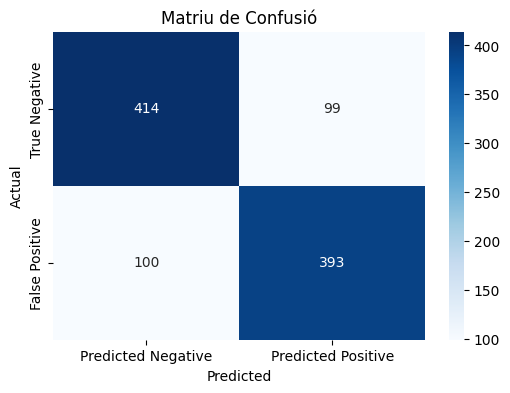

In [158]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['False', 'True'])
print(report)
y_proba = clf.predict_proba(X_test)[:, 1]


fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)


plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='red', lw=2, label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

y_pred = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
labels = ['True Negative', 'False Positive']
labels2 = ['Predicted Negative', 'Predicted Positive']
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels2, yticklabels=labels)
plt.title('Matriu de Confusió')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


